#Librerias

In [1]:
!pip install unidecode


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from google.colab import drive
import re  # Import the 're' module for regular expressions
from unidecode import unidecode


#limpiar_mercadoli

In [3]:
def move_columns(dataframe, column_order):
    """
    Mueve las columnas de un DataFrame según el orden especificado.

    Parameters:
        dataframe (pd.DataFrame): El DataFrame a reorganizar.
        column_order (list): Una lista que contiene el nombre de las columnas en el orden deseado.

    Returns:
        pd.DataFrame: El DataFrame reorganizado.
    """
    # Verificar que todas las columnas del orden estén presentes en el DataFrame
    assert set(column_order).issubset(dataframe.columns), "No todas las columnas del orden están presentes en el DataFrame."

    # Crear una lista con las columnas que no están en el orden especificado
    remaining_columns = [col for col in dataframe.columns if col not in column_order]

    # Concatenar las columnas en el orden deseado
    new_dataframe = pd.concat([dataframe[col] for col in column_order], axis=1)

    # Agregar las columnas restantes al final del DataFrame
    for col in remaining_columns:
        new_dataframe[col] = dataframe[col]

    return new_dataframe

In [4]:
# Definir la lista de departamentos a extraer
departamentos = [
    'Bogotá ','Antioquia','Valle Del Cauca','Cundinamarca','Santander','Atlántico','Risaralda','Boyaca','Caldas','Villavicencio','Valledupar',
    'Sucre','Quindio','Cauca','Tolima','Huila','Cesar','Nariño','Bolívar','Casanare','Choco','Meta','Magdalena','Caqueta','Putumayo','Guajira','Córdoba',
    'Magdalena','Guaviare','Arauca']

In [5]:
def limpiar_mercadoli(df):

    # Crear un nuevo DataFrame con la columna "Año"
    df_año = pd.DataFrame(df['Año'])

    años = df_año.iloc[::2].reset_index(drop=True)
    kilometros = df_año.iloc[1::2].reset_index(drop=True)

    # Renombrar las columnas
    años.columns = ['Año']
    kilometros.columns = ['Kilometros']

    df = df.drop('Año', axis=1)

    df = pd.concat([df, kilometros, años], axis=1)

    df = df.dropna()


    # Split the text into two columns
    df[['Brand', 'Model_Description']] = df['Modelo'].str.split(n=1, expand=True)


    # Split the text into two columns
    df[['Modelos', 'Descripcion']] = df['Model_Description'].str.split(n=1, expand=True)

    df = df.drop(columns=['Model_Description', 'Modelo','Unnamed: 0'])

    # Crear una expresión regular para buscar los departamentos en la columna 'Ciudad_Departamento'
    regex_departamentos = '|'.join(departamentos)

    # Extraer el departamento y almacenarlo en una nueva columna 'Departamento'
    df['Departamento'] = df['Ciudad'].str.extract(f'({regex_departamentos})', flags=re.IGNORECASE)

    df = df.drop(columns=['Ciudad'])

    # Quitar el KM de la columna kilometros
    df['Kilometros'] = df['Kilometros'].apply(lambda x: re.sub(r'\D', '', str(x)))

    df['Precio'] = df['Precio'].apply(lambda x: re.sub(r'\D', '', str(x)))

    df = move_columns(df, ['Brand','Modelos', 'Precio', 'Año','Kilometros', 'Departamento','Descripcion' ])

    for column in df.columns:
            if df[column].dtype == 'object':  # Filtrar columnas de tipo objeto
                df[column] = df[column].str.lower().str.strip()
                df[column] = df[column].apply(lambda x: unidecode(x) if isinstance(x, str) else x)  # Aplicar unidecode solo si es str


    #cambiar nombre columna
    df.rename(columns={'Departamento': 'Ciudad'}, inplace=True)
    df.rename(columns={'Modelos': 'modelo'}, inplace=True)

    df['Precio'] = df['Precio'].str.replace('$', '').str.replace('.', '').astype(float)


    ciudades = ['quindio','bogota','valle del cauca','antioquia','santander','valledupar','risaralda','cundinamarca','tolima','caldas','villavicencio']
    df = df[df['Ciudad'].isin(ciudades)]



    return df



#limpiar_carroYa

In [6]:
def limpiar_carroYa(df):
    # separar los datos de la columna modelo
    df[['Brand', 'modelo']] = df['Modelo'].str.split(n=1, expand=True)

    # Split the text into two columns
    #df[['Modelos', 'Descripcion']] = df['Model_Description'].str.split(n=1, expand=True)
    df = df.drop(columns=['Modelo','Unnamed: 0'])

    #cambiar nombre columna
    df.rename(columns={'Año.1': 'Kilometros'}, inplace=True)

    # Quitar el KM de la columna kilometros
    df['Kilometros'] = df['Kilometros'].apply(lambda x: re.sub(r'\D', '', str(x)))

    #Quitar el signo de $ de la columna Precio
    df['Precio'] = df['Precio'].str.replace('$', '').str.replace('.', '').astype(float)


    #Procesamiento de columna de texto - volver todas las columnas a minuscula y quitar espacios al principio y final.
    for column in df.columns:
            if df[column].dtype == 'object':  # Filtrar columnas de tipo objeto
                df[column] = df[column].str.lower().str.strip()


    #ciudades = ['bogota','cali','medellin','barranquilla','bucaramanga','pereira','chia','ibague','manizales','villavicencio']
    #df = df[df['Ciudad'].isin(ciudades)]

    df = move_columns(df, ['Brand', 'modelo','Precio', 'Año', 'Kilometros', 'Ciudad'])


    #remplazar las ciudades por los departamentos correspondientes

    # Mapeo de modelos
    ciudad_mapping = {
        'bogota': 'cundinamarca',
        'ibague': 'tolima',
        'medellin': 'antioquia',
        'manizales': 'caldas',
        'meta': 'villavicencio',
        'barranquilla': 'atlantico',
        'cali': 'valle del cauca',
        'bucaramanga': 'santander',
        'chia': 'cundinamarca',
        'meta': 'villavicencio',
        'pereira': 'risaralda'}

    column_mapping = {
        'Ciudad': ciudad_mapping
    }
    '''
    for column, mapping in column_mapping.items():
        if column in df.columns and df[column].dtype == 'object':
            df[column] = df[column].map(mapping)
    '''
    return df



#unir y actualizar_dataframe

In [7]:
def actualizar_dataframe(df_existente, df_nuevo):
    # Agregar datos del nuevo DataFrame al existente
    df_existente = pd.concat([df_existente, df_nuevo], ignore_index=True)
    print(len(df_existente))
    df_existente =  df_existente.drop_duplicates()
    print(len(df_existente))

    return df_existente

#unificar_variables_categoricas

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



#Cargar datos

In [11]:
mercadoLi = pd.read_csv("/content/drive/MyDrive/Proyecto_carros/Datos_carros/MercadoLibre/mercadolibre_5-04-2024.csv")

carroYa = pd.read_csv("/content/drive/MyDrive/Proyecto_carros/Datos_carros/CarroYa/carroya_5-04-2024.csv")

In [12]:
df_mercadoLi = limpiar_mercadoli(mercadoLi)

df_carroYa = limpiar_carroYa(carroYa)


In [13]:
datos_unidos = actualizar_dataframe(df_carroYa,df_mercadoLi)
datos_unidos

61863
61254


,Brand,modelo,Precio,Año,Kilometros,Ciudad,Descripcion
0,audi,q3,64800000.0,2014,53252,bucaramanga,2.0 tfsi quattro luxury
1,chevrolet,tracker,53000000.0,2016,47200,bogota,NaN
2,renault,stepway,51700000.0,2018,58700,medellin,trek intens
3,honda,cr-v,115000000.0,2018,75000,cali,1.5 exl 4wd
4,renault,kwid,37000000.0,2022,17822,cali,life
...,...,...,...,...,...,...,...
61858,fiat,uno,32000000.0,2018,57000,quindio,1.4 way
61859,fiat,uno,44000000.0,2020,11000,bogota,1.4 way
61860,fiat,uno,36500000.0,2019,47000,cundinamarca,1.4 way
61861,fiat,uno,41000000.0,2020,45120,valle del cauca,1.4 way


#extraer_cilindraje

In [14]:
def extraer_cilindraje(df):
    # Expresión regular con grupos de captura para buscar números con un punto en el medio
    pattern = r'(\d+\.\d+)'

    # Aplicar la expresión regular a la columna 'descripcion' y extraer los valores
    df['cilindraje'] = df['Descripcion'].str.extract(pattern)

    return df

In [15]:
df_cilindraje = extraer_cilindraje(datos_unidos)
df_cilindraje

,Brand,modelo,Precio,Año,Kilometros,Ciudad,Descripcion,cilindraje
0,audi,q3,64800000.0,2014,53252,bucaramanga,2.0 tfsi quattro luxury,2.0
1,chevrolet,tracker,53000000.0,2016,47200,bogota,NaN,NaN
2,renault,stepway,51700000.0,2018,58700,medellin,trek intens,NaN
3,honda,cr-v,115000000.0,2018,75000,cali,1.5 exl 4wd,1.5
4,renault,kwid,37000000.0,2022,17822,cali,life,NaN
...,...,...,...,...,...,...,...,...
61858,fiat,uno,32000000.0,2018,57000,quindio,1.4 way,1.4
61859,fiat,uno,44000000.0,2020,11000,bogota,1.4 way,1.4
61860,fiat,uno,36500000.0,2019,47000,cundinamarca,1.4 way,1.4
61861,fiat,uno,41000000.0,2020,45120,valle del cauca,1.4 way,1.4


#crear_año

In [16]:
def crear_año(df, columna_año):
    # Asegurarse de que la columna de año sea numérica
    df[columna_año] = pd.to_numeric(df[columna_año], errors='coerce')  # Convertir a número, errores a NaN
    if '2023' not in df.columns:
        df['2023'] = 2023  # Crear una columna '2023' con el valor 2023 si no existe
    df['Edad'] = df['2023'] - df[columna_año]
    if columna_año in df.columns:
        df.drop([columna_año,'2023'], axis=1, inplace=True)  # Eliminar la columna 'Año'
    return df

In [26]:
coordenadas_colombia = {
    'cundinamarca': {'latitud': 4.6, 'longitud': -74.2},
    'antioquia': {'latitud': 6.55, 'longitud': -75.83},
    'caldas': {'latitud': 5.17, 'longitud': -75.77},
    'atlantico': {'latitud': 10.7, 'longitud': -74.87},
    'quindio': {'latitud': 4.47, 'longitud': -75.7},
    'valle del cauca': {'latitud': 3.83, 'longitud': -76.5},
    'bolivar': {'latitud': 8.75, 'longitud': -74.17},
    'risaralda': {'latitud': 5.17, 'longitud': -75.77},
    'ibague': {'latitud': 4.43, 'longitud': -75.23},
    'nariño': {'latitud': 1.28, 'longitud': -77.4},
    'cesar': {'latitud': 9.33, 'longitud': -73.58},
    'santander': {'latitud': 6.67, 'longitud': -73.25},
    'norte de santander': {'latitud': 7.92, 'longitud': -72.5},
    'cauca': {'latitud': 2.43, 'longitud': -76.62},
    'huila': {'latitud': 2.53, 'longitud': -75.53}
}

def agregar_coordenadas(df, columna_ciudad='ciudad'):
    # Función para asignar latitud y longitud a cada ciudad
    def asignar_coordenadas(ciudad):
        ciudad = ciudad.lower()
        return coordenadas_colombia.get(ciudad, {'latitud': None, 'longitud': None})

    # Aplicar la función a la columna "ciudad" para obtener latitud y longitud
    df[['latitud', 'longitud']] = df[columna_ciudad].apply(lambda x: pd.Series(asignar_coordenadas(x)))

    # Agregar la columna "coordenadas" como el producto de latitud y longitud
    df['coordenadas'] = df['latitud'] * df['longitud']

    # Eliminar las columnas "latitud" y "longitud"
    df.drop(['latitud', 'longitud'], axis=1, inplace=True)


In [ ]:
#agregar_coordenadas(sales,'Ciudad')

#agregar_columna_ciudades_capitales

In [17]:
ciudades = [
    "bogota",
    "medellin",
    "cali",
    "barranquilla",
    "cartagena",
    "cucuta",
    "bucaramanga",
    "villavicencio",
    "santa marta",
    "valledupar",
    "ibague",
    "monteria",
    "pereira",
    "manizales",
    "pasto",
    "neiva",
    "popayan",
    "armenia",
    "sincelejo",
    "riohacha",
    "tunja",
    "yopal",
    "florencia",
    "quibdo",
    "arauca",
    "mocoa",
    'medellin - antioquia',
    'suba - bogota d.c.',
    'cali - valle del cauca',
    'barranquilla - atlantico',
    'kennedy - bogota d.c.'
    'puente aranda - bogota d.c.',
    'pereira - risaralda',
    "fontibon - bogota d.c.",
    "bucaramanga - santander",
    "manizales - caldas",
    "ibague - tolima",
    "armenia - quindio",
    "cucuta - norte de santander	"

]

In [18]:
def agregar_columna_ciudades_capitales(df, ciudades_capitales):
    # Crea una nueva columna llamada 'EsCapital' llena de ceros
    df['EsCapital'] = 0

    # Marca con 1 las filas cuya ciudad está en la lista de ciudades capitales
    df.loc[df['Ciudad'].isin(ciudades_capitales), 'EsCapital'] = 1

    return df


In [ ]:
#sales = agregar_columna_ciudades_capitales(sales,ciudades)
#sales

#unificar_variables_categoricas

In [ ]:
def unificar_variables_categoricas(df, column_mapping):
    """
    Unifica las variables categóricas según el mapeo proporcionado.

    Args:
        df (pd.DataFrame): El DataFrame original.
        column_mapping (dict): Un diccionario que mapea variables originales a un valor unificado.

    Returns:
        pd.DataFrame: El DataFrame con las variables categóricas unificadas.
    """
    df_copy = df.copy()  # Copia del DataFrame para evitar modificar el original

    for column, mapping in column_mapping.items():
        if column in df_copy.columns and df_copy[column].dtype == 'object':
            df_copy[column] = df_copy[column].map(mapping)

    return df_copy

# Mapeo de modelos
ciudad_mapping = {
    'medellin - antioquia': 'antioquia',
    'bogota': 'cundinamarca',
    'suba - bogota d.c.': 'cundinamarca',
    'cali - valle del cauca': 'valle del cauca',  # Unificar "Camry" con "Corolla" en este ejemplo
    'usaquen - bogota d.c.': 'cundinamarca',
    'engativa - bogota d.c.': 'cundinamarca',
    'barranquilla - atlantico': 'atlantico',
    'cali': 'valle del cauca',
    'kennedy - bogota d.c.': 'cundinamarca',  # Unificar "Camry" con "Corolla" en este ejemplo
    'puente aranda - bogota d.c.': 'cundinamarca',
    'pereira - risaralda': 'risaralda',
    'fontibon - bogota d.c.': 'cundinamarca',
    'medellin': 'antioquia',
    'envigado - antioquia': 'antioquia',
    'bucaramanga - santander': 'santander',
    'barrios unidos - bogota d.c.': 'cundinamarca',
    'teusaquillo - bogota d.c.': 'cundinamarca',
    'chapinero - bogota d.c.': 'cundinamarca',
    'chia - cundinamarca': 'cundinamarca',
    'manizales - caldas': 'caldas',
    'barranquilla': 'atlantico',
    'sabaneta - antioquia': 'antioquia',
    'ibague - tolima': 'ibague',
    'cucuta - norte de santander': 'norte de santander',
    'armenia - quindio': 'quindio',
    'cartagena de indias - bolivar': 'bolivar',
    'bello - antioquia': 'antioquia',
    'itagui - antioquia': 'antioquia',
    'rionegro - antioquia': 'antioquia',
    'pereira': 'risaralda',
    'manizales': 'caldas',
    'ibague': 'ibague',
    'neiva - huila': 'huila',
    'dosquebradas - risaralda': 'risaralda',
    'pasto - nariño': 'nariño',
    'valledupar - cesar': 'cesar',
    'popayan - cauca': 'cauca',
    'bogota - cundinamarca': 'cundinamarca',
    'cartagena': 'bolivar',
    'armenia': 'quindio',
    'cundinamarca': 'cundinamarca',
    'caldas': 'caldas',
    'atlantico': 'atlantico',
    'antioquia': 'antioquia',
    'valle del cauca': 'valle del cauca',
    'santander': 'santander',
    'risaralda': 'risaralda',
    'tolima': 'ibague',
    'valledupar': 'cesar',
    'quindio': 'quindio',
    'villavicencio': 'villavicencio'

}
column_mapping = {
    'Ciudad': ciudad_mapping,
}

In [ ]:
df_reducir_ciudades = unificar_variables_categoricas(df,column_mapping)
df_reducir_ciudades

#Valores nulos en cada variable

In [ ]:
df = df_cilindraje
# Check for missing values
print(df.isnull().sum())

# Create function to check percentage of missing values
def check_missing_value(df):
    missing_value_percentage = (df.isnull().sum().sum()/df.shape[0]) * 100
    print(f"Total missing values {round(missing_value_percentage,2)}%")

check_missing_value(df)

In [ ]:
# Eliminar filas con valores nulos
df_sin_nulos = df_cilindraje.dropna()
# Supongamos que tienes un DataFrame llamado 'df'
df_sin_nulos.reset_index(drop=True, inplace=True)
df_sin_nulos

In [ ]:
# Eliminar la columna "descripcion"
df_sin_descripcion = df.drop('Descripcion', axis=1)
df_procesado= df_sin_descripcion

#Distribuciones de las variables numericas

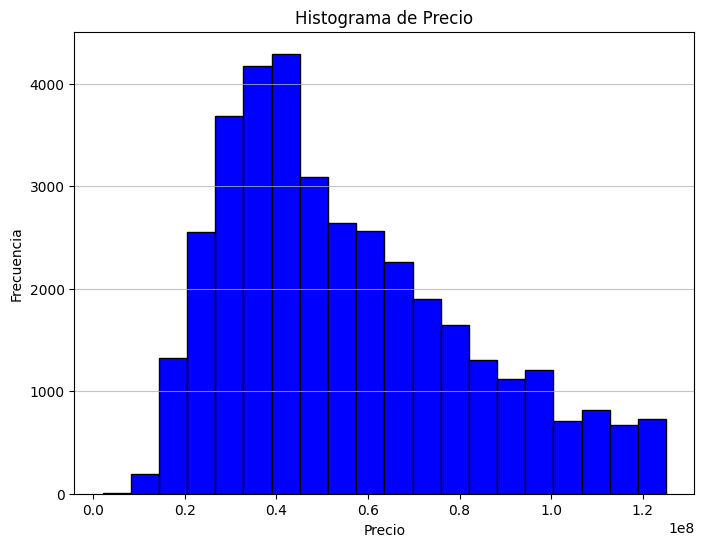

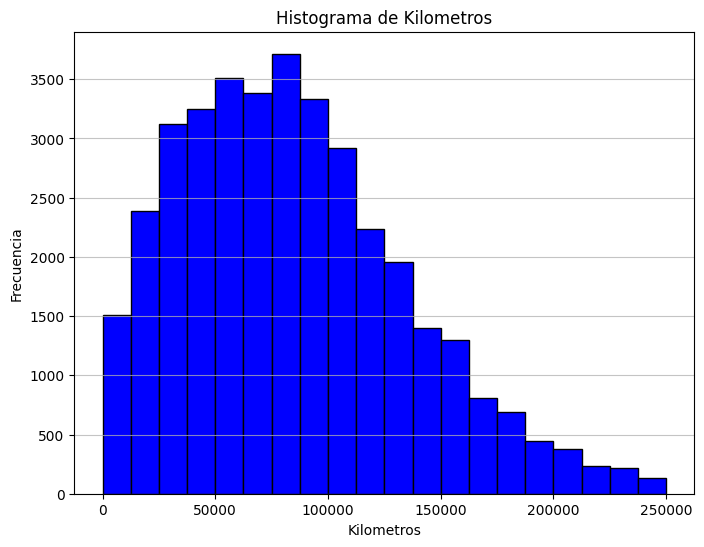

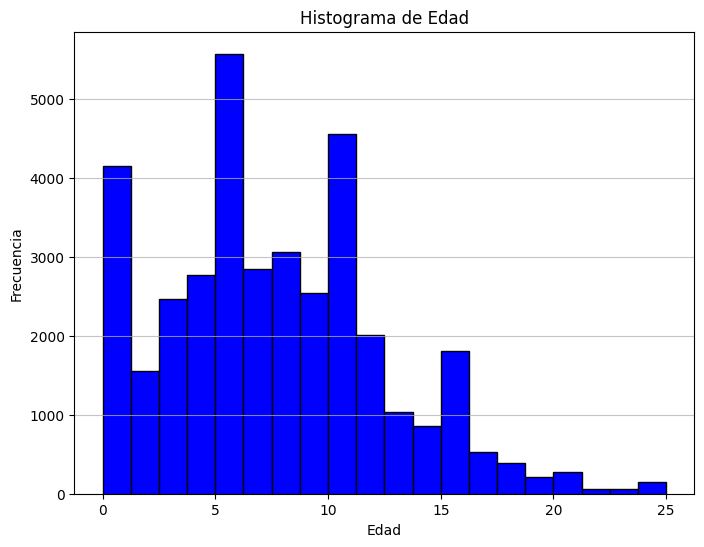

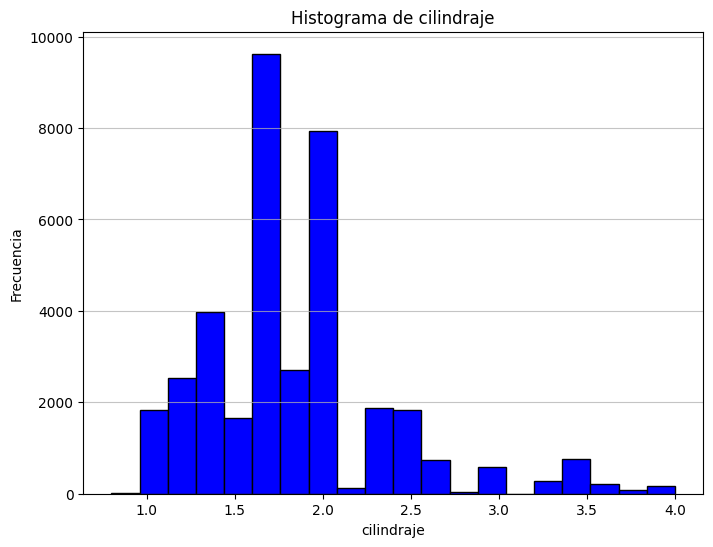

In [36]:
import matplotlib.pyplot as plt

def mostrar_histograma(df, columnas):
    """
    Muestra histogramas para las columnas especificadas en un DataFrame.

    Args:
        df (pandas.DataFrame): El DataFrame que contiene los datos.
        columnas (list): Lista de nombres de columnas para las cuales mostrar el histograma.
    """
    for columna in columnas:
        plt.figure(figsize=(8, 6))
        plt.hist(df[columna], bins=20, color='blue', edgecolor='black')
        plt.title(f'Histograma de {columna}')
        plt.xlabel(columna)
        plt.ylabel('Frecuencia')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

# Ejemplo de uso
mostrar_histograma(df, ['Precio', 'Kilometros', 'Edad', 'cilindraje'])

In [34]:
df_codificado

,Brand,Precio,Kilometros,Ciudad,cilindraje,Edad,EsCapital,coordenadas,modelo_1023,modelo_106,...,modelo_y380,modelo_yaris,modelo_yeti,modelo_yoki,modelo_yoya,modelo_yoyo,modelo_z4,modelo_zafira,modelo_zonora,modelo_zs
0,0.012214,115000000.0,75000,0.125961,1.5,5,1,-292.995,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.208401,25000000.0,64478,0.125961,1.0,11,1,-292.995,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.156023,86000000.0,56286,0.125961,1.3,0,1,-292.995,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.208401,32000000.0,58000,0.509696,1.8,12,1,-341.320,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.106895,28500000.0,116000,0.509696,1.6,15,1,-341.320,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36919,0.003385,13000000.0,150000,0.509696,1.3,17,1,-341.320,0,0,...,0,0,0,0,0,0,0,0,0,0
36920,0.003385,32000000.0,57000,0.010535,1.4,5,0,-338.379,0,0,...,0,0,0,0,0,0,0,0,0,0
36921,0.003385,44000000.0,11000,0.509696,1.4,3,1,-341.320,0,0,...,0,0,0,0,0,0,0,0,0,0
36922,0.003385,36500000.0,47000,0.509696,1.4,4,0,-341.320,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df1= sales.query("Precio<=1.25105 *10**8")

df1= df1.query("Kilometros<=0.25 *10**6")

df1= df1.query("Edad<=25")

df1= df1.query("Edad>=0")


dfb= df1.query("cilindraje<=4")

#codificar_one_hot

In [29]:
def codificar_one_hot(df, columnas_categoricas):
    # Utiliza get_dummies para codificar en formato one-hot las columnas especificadas.
    df_encoded = pd.get_dummies(df, columns=columnas_categoricas, prefix=columnas_categoricas, dtype=int)
    return df_encoded

#frequency_encode_columns

In [22]:
def frequency_encode_columns(df, columns):
    encoded_df = df.copy()
    for column in columns:
        # Calcula la frecuencia de cada categoría en la columna
        freq = df[column].value_counts(normalize=True).to_dict()
        # Aplica la codificación de frecuencia a la columna
        encoded_df[column] = df[column].map(freq)
    return encoded_df

In [30]:
columnas1 = ['modelo']
df_codificado = codificar_one_hot(df,columnas1)

columnas2 = ['Brand','Ciudad']
df_codificado = frequency_encode_columns(df_codificado,columnas2)
df_codificado

,Brand,Precio,Kilometros,Ciudad,cilindraje,Edad,EsCapital,coordenadas,modelo_1023,modelo_106,...,modelo_y380,modelo_yaris,modelo_yeti,modelo_yoki,modelo_yoya,modelo_yoyo,modelo_z4,modelo_zafira,modelo_zonora,modelo_zs
0,0.012214,115000000.0,75000,0.125961,1.5,5,1,-292.995,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.208401,25000000.0,64478,0.125961,1.0,11,1,-292.995,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.156023,86000000.0,56286,0.125961,1.3,0,1,-292.995,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.208401,32000000.0,58000,0.509696,1.8,12,1,-341.320,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.106895,28500000.0,116000,0.509696,1.6,15,1,-341.320,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36919,0.003385,13000000.0,150000,0.509696,1.3,17,1,-341.320,0,0,...,0,0,0,0,0,0,0,0,0,0
36920,0.003385,32000000.0,57000,0.010535,1.4,5,0,-338.379,0,0,...,0,0,0,0,0,0,0,0,0,0
36921,0.003385,44000000.0,11000,0.509696,1.4,3,1,-341.320,0,0,...,0,0,0,0,0,0,0,0,0,0
36922,0.003385,36500000.0,47000,0.509696,1.4,4,0,-341.320,0,0,...,0,0,0,0,0,0,0,0,0,0


#Seleccionar marcas mas populares

In [37]:
marcas = ['kia', 'renault', 'chevrolet', 'ford', 'volkswagen', 'fiat',
       'mazda', 'toyota', 'nissan', 'hyundai',  'peugeot',
       'suzuki', 'bmw', 'honda', 'volvo', 'audi', 'subaru',
       'dodge', 'seat', 'jeep', 'chery', 'citroen',
       'ssangyong', 'mitsubishi','mercedes-benz' ]

df1 = df[df['Brand'].isin(marcas)]

In [38]:
df1

,Brand,modelo,Precio,Kilometros,Ciudad,cilindraje,Edad,EsCapital,coordenadas
0,honda,cr-v,115000000.0,75000,valle del cauca,1.5,5,1,-292.995
1,chevrolet,spark,25000000.0,64478,valle del cauca,1.0,11,1,-292.995
2,renault,duster oroch,86000000.0,56286,valle del cauca,1.3,0,1,-292.995
3,chevrolet,cruze,32000000.0,58000,cundinamarca,1.8,12,1,-341.320
4,mazda,3,28500000.0,116000,cundinamarca,1.6,15,1,-341.320
...,...,...,...,...,...,...,...,...,...
36919,fiat,uno,13000000.0,150000,cundinamarca,1.3,17,1,-341.320
36920,fiat,uno,32000000.0,57000,quindio,1.4,5,0,-338.379
36921,fiat,uno,44000000.0,11000,cundinamarca,1.4,3,1,-341.320
36922,fiat,uno,36500000.0,47000,cundinamarca,1.4,4,0,-341.320


In [ ]:
drive.mount('/content/drive')

#Cargar datos

In [20]:
 df = pd.read_csv("/content/drive/MyDrive/Proyecto_carros/Datos_carros/Datos_procesados/datos_procesados_9-04-2024.csv")


#Guardar datos

In [32]:
nombre_archivo = 'datos_procesados_11-04-2024.csv' #cambiar fecha cada que se va a guardar
df_codificado.to_csv(f'/content/drive/MyDrive/Proyecto_carros/Datos_carros/Datos_procesados/{nombre_archivo}', index=False)
